In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# from sklearn.model_selection import train_test_split


In [46]:
# Converts a list of time-series data in to supervised data set.
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
            data: Sequence of observations as a list or NumPy array.
            n_in: Number of lag observations as input (X).
            n_out: Number of observations as output (y).
            dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
            Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]

    df = pd.DataFrame(data)

    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [47]:
births = pd.read_csv(
    "../datasets/daily-total-female-births/daily-total-female-births.csv",
    header=0,
    index_col=0,
)


Check Lists:

- **Assumption**: The amount to brithes is related to the amount of birth few days ago
- We can use random forest to predict the amount of birth given a few days of historical data
- Has missing value?
  No (series[series.isna()].count())
- Timeseries data interval?
  (1 day, since 1st element in head is Jan 1st, last element in tail is Dec 31st)
- Amount of columns?
  1 column (Births), the date will be ignored
- Amount of rows?
  365 (Not enough, one assumption is after certain amount of time, there may be 2nd child born, so the birth rate may have a pattern / season? for each 10 or 12 months)
- Data type
  int64
- Unit of feature
  amount of births in each day
- Any outliers?
  Yes, there is a Births value == 73, but fortime series, outliner cannot be simple ignored, How?
- Feature doesn't contains a lot of outliers
- Feature is not capped, distributed in a bell shape
- Residual type? What is residual type?

Plan:

1. Convert the time series to various supervised learnaing problems with to 1 10, 20 and 30 days sliding window width
2. For each series, split to train and test set, and cannot use random splitting, so the splitting function need to use write
3. For each series, train the random forest model with default setting and compare the result


In [75]:
def random_forest_forecast(train, predictor):
    """
    Takes training, testing and predictors, return prediction'
    Return:
            List of predictions
    """
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]

    model = RandomForestRegressor(n_estimators=100)
    model.fit(trainX, trainy)
    print(trainX)
    print(trainy)

    yhat = model.predict(predictor)
    print(predictor)

    return yhat


In [76]:
def walk_forward_validation(data, n_test=10):
    train = data[:-n_test]
    test = data[-n_test:]

    predictions = list()
    # Initialize the history
    history = [x for x in train]

    for i in range(len(test)):
        hist_array = np.asarray(history)

        test_X = test[:, :-1]
        test_y = test[:, -1]

        yhat = random_forest_forecast(history, test_X)

        predictions.append(yhat[0])

        history.append(test[i])

        # Summarize progress
        print("> expected=%.1f, predicted=%.1f" % (test_y[i], yhat[0]))

    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions


In [65]:
birth_supervised = series_to_supervised(births['Births'].values.tolist(), n_in=1, n_out=1)

In [77]:
error, test, prediction = walk_forward_validation(birth_supervised.values, 20)


[[35.]
 [32.]
 [30.]
 [31.]
 [44.]
 [29.]
 [45.]
 [43.]
 [38.]
 [27.]
 [38.]
 [33.]
 [55.]
 [47.]
 [45.]
 [37.]
 [50.]
 [43.]
 [41.]
 [52.]
 [34.]
 [53.]
 [39.]
 [32.]
 [37.]
 [43.]
 [39.]
 [35.]
 [44.]
 [38.]
 [24.]
 [23.]
 [31.]
 [44.]
 [38.]
 [50.]
 [38.]
 [51.]
 [31.]
 [31.]
 [51.]
 [36.]
 [45.]
 [51.]
 [34.]
 [52.]
 [47.]
 [45.]
 [46.]
 [39.]
 [48.]
 [37.]
 [35.]
 [52.]
 [42.]
 [45.]
 [39.]
 [37.]
 [30.]
 [35.]
 [28.]
 [45.]
 [34.]
 [36.]
 [50.]
 [44.]
 [39.]
 [32.]
 [39.]
 [45.]
 [43.]
 [39.]
 [31.]
 [27.]
 [30.]
 [42.]
 [46.]
 [41.]
 [36.]
 [45.]
 [46.]
 [43.]
 [38.]
 [34.]
 [35.]
 [56.]
 [36.]
 [32.]
 [50.]
 [41.]
 [39.]
 [41.]
 [47.]
 [34.]
 [36.]
 [33.]
 [35.]
 [38.]
 [38.]
 [34.]
 [53.]
 [34.]
 [34.]
 [38.]
 [35.]
 [32.]
 [42.]
 [34.]
 [46.]
 [30.]
 [46.]
 [45.]
 [54.]
 [34.]
 [37.]
 [35.]
 [40.]
 [42.]
 [58.]
 [51.]
 [32.]
 [35.]
 [38.]
 [33.]
 [39.]
 [47.]
 [38.]
 [52.]
 [30.]
 [34.]
 [40.]
 [35.]
 [42.]
 [41.]
 [42.]
 [38.]
 [24.]
 [34.]
 [43.]
 [36.]
 [55.]
 [41.]
 [45.]

/tmp/ipykernel_60928/2561726589.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


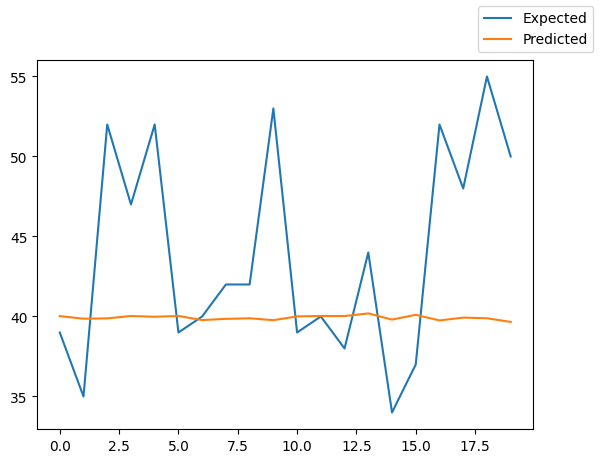

In [78]:
fig, axes = plt.subplots(1, 1)

axes.plot(test, label="Expected")
axes.plot(prediction, label="Predicted")

fig.legend()
fig.show()


In [43]:
supervised_set = series_to_supervised(
    series["Births"].values.tolist(), n_in=10, n_out=1
)

error, test, prediction = walk_forward_validation(supervised_set.values, 20)



5.8624620251165025
5.955299999999999
5.9141
5.9148499999999995


/tmp/ipykernel_60928/32788136.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


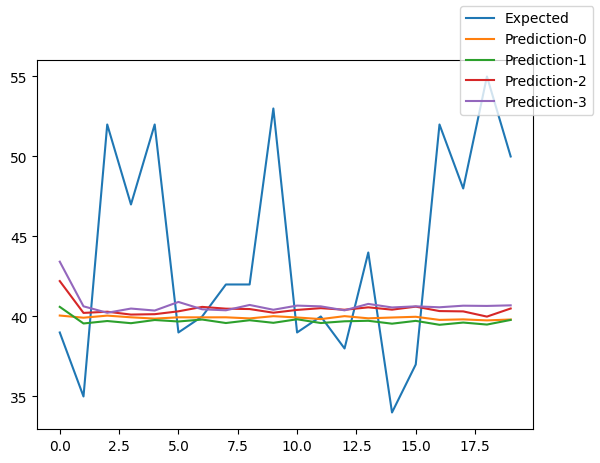

In [44]:
window_width = [1, 10, 20, 30]

predictions = list()

for ww in window_width:
    supervised_set = series_to_supervised(
        series["Births"].values.tolist(), n_in=ww, n_out=1
    )
    error, test, prediction = walk_forward_validation(supervised_set.values, 20)
    print(error)
    predictions.append(prediction)

fig, axes = plt.subplots(1, 1)

axes.plot(test, label="Expected")

counter = 0

for p in predictions:
      axes.plot(p, label="Prediction-{}".format(counter))
      counter += 1

fig.legend()
fig.show()

/tmp/ipykernel_60928/3617345307.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


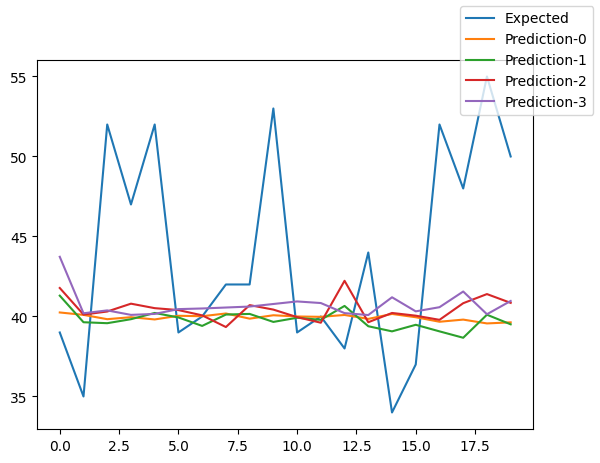

In [39]:
fig, axes = plt.subplots(1, 1)

axes.plot(test, label="Expected")

counter = 0

for p in predictions:
      axes.plot(p, label="Prediction-{}".format(counter))
      counter += 1

fig.legend()
fig.show()

In [ ]:
fig, axes = plt.subplots(1, 1)

axes.plot(test, label="Expected")
axes.plot(prediction, label="Predicted")

fig.legend()
fig.show()


In [ ]:
test


In [ ]:
prediction


In [ ]:
series.hist()


In [ ]:
series.plot(kind="line")


In [ ]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
    train = np.asarray(train)

    # splot into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]

    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)

    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]


In [ ]:
# Walk-forward validation for univariate data


def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)

    # Seed history with training dataset
    history = [x for x in train]

    # Step over each time-step in the test set
    for i in range(len(test)):

        # Split test tow into input and output columns
        testX, testy = test[i, :-1], test[i, -1]

        # Fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)

        # Store forecase in list of predictions
        predictions.append(yhat)

        # add actual observation to history for the next loop
        history.append(test[i])

        # Summarize progress
        print(">expected=%.1f, predicted=%.1f" % (testy, yhat))

    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions


In [ ]:
series = pd.read_csv(
    "../datasets/daily-total-female-births/daily-total-female-births.csv",
    header=0,
    index_col=0,
)
values = series.values


In [ ]:
series.head()


In [ ]:
fig, axes = plt.subplots(1, 1)
axes.plot(series["Births"])


In [ ]:
# evaluate the Random Forest model on the dataset when making one-step forecasts for the last 12 months of data.

values = series.values

# transform a time series dataset into a supervised learning dataset
data = series_to_supervised(values, n_in=6)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)


In [ ]:
fig, axes = plt.subplots(1, 1)

axes.plot(y, label="Expected")
axes.plot(yhat, label="Predicted")

fig.legend()
fig.show()


In [ ]:
mae
